# Preprocessing of allstations_batch2

Years: 2019 to 2009 (total = 11 years)

Some station-years are not yet finished for this period.

2020 needs review.

The last report stated that KDTX-2017 needed review. It did have an unusual number of roosts in the beginning of September, but the roosts are legit. KMKX-2019 and KGRB-2010 also needed review because of days where `"viewed" == False`, and that was fixed for this report. 

Typos in KTYX track notes were also fixed for this report.

## Load libraries

In [31]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

## Merge annotations

This creates a single dataset with all the annotations. Notice that in this dataset, called `df`, there will be both roosts and non-roosts.

Note: each annotation file has detections from June 1st to December 31st.

In [32]:
batch = "allstations_batch2"

In [33]:
# Set directoy to look for files:
data_dir = "../../data/raw_annotations/" + batch + "/" + batch + "/" 

dir_list = os.listdir(data_dir)

i = 0

for folder in dir_list[0:-1]:

    # List files inside each folder:
    file_list = os.listdir(data_dir + "/" + folder)

    for file in file_list:
         
        if i == 0:
        
            df = pd.read_csv(data_dir + "/" + folder + "/" + file)
        
        else:
        
            if file.endswith(".csv"):
                new_df = pd.read_csv(data_dir + "/" + folder + "/" + file)
                df = pd.concat([df, new_df])
        
        i = i + 1

        
# Convert to dates and times:
df["date"] = pd.to_datetime(df["date"], format = '%Y%m%d')
df["year"] = df.apply(lambda x: x["date"].year, axis=1)
df["day"] = df.apply(lambda x: x["date"].day, axis=1)
df["month"] = df.apply(lambda x: x["date"].month, axis=1)
df["time"] = pd.to_datetime(df["time"], format = '%H%M%S')

print("Read " + str(i + 1) + " files.")

Read 124 files.


In [34]:
# Make all notes lowercase:
df.notes = df["notes"].str.lower()

print("Number of detections with each note:")
df["notes"].value_counts()

Number of detections with each note:


long       1267
large       842
rn          662
shrinks     178
nr           61
Name: notes, dtype: int64

In [35]:
# Make all notes for the day lowercase:
df.day_notes = df["day_notes"].str.lower()

In [36]:
# There were occasions where "cluster" was labelled "clusters", fix it:
df = df.replace("clusters", "cluster")

# There were occasions where "pap" was labelled "psp", fix it:
df = df.replace("psp", "pap")

In [37]:
# Number of tracks before filtering:
len(df.track_id.unique())

161331

In [38]:
# Number of detections before filtering:
len(df)

307885

In [39]:
# Number of days before filtering:
len(df.date.unique())

3156

## Filter roosts

In [40]:
# Filter only roosts (remove non-roost and duplicate):
roosts = df[(df['label'] != 'non-roost') & (df['label'] != 'duplicate')]

# Filter the general dataset to get only detections from June to October (inclusive):
screen_start = 6
screen_end = 10

roosts = roosts[(roosts["month"]>= screen_start) & (roosts["month"] <= screen_end)]

# Remove days noted as "ap" or as "weather":
roosts = roosts[(roosts.day_notes != "ap") & (roosts.day_notes != "weather")]

# Get a single index column for all detections::
roosts.reset_index(drop=True, inplace=True)

# Create a unique identifier for each single detection (each row in the dataset):
detection_id = []

for i in range(0, len(roosts)):
    if i <= 9:
        identifier = "DET00000" + str(i)

    elif (i >= 10) and (i<100):
        identifier = "DET0000" + str(i)

    elif (i >= 100) and (i<1000):
        identifier = "DET000" + str(i)

    elif (i >= 1000) and (i<10000):
        identifier = "DET00" + str(i)
    
    elif (i >= 10000) and (i < 100000):
        identifier = "DET0" + str(i)
    
    elif (i >= 100000) and (i < 1000000):
        identifier = "DET" + str(i)

    detection_id.append(identifier)

roosts["detection_id"] = detection_id


## Some sanity checks

In [13]:
# Number of tracks after filtering:
len(roosts.track_id.unique())

7490

In [14]:
# Number of detections after filtering:
len(roosts)

31683

In [15]:
# Check if all detections have only ONE occurrence (this output should be ZERO):
sum(roosts.detection_id.value_counts()>=2)

0

In [16]:
# Check if only the desired labels were added and print relative frequency of each one:
roosts.label.value_counts()/len(roosts)

swallow-roost          0.797841
bad-track              0.083925
unknown-noise-roost    0.070669
weather-roost          0.041473
AP-roost               0.006092
Name: label, dtype: float64

In [17]:
# Number of detections per station:
roosts.station.value_counts()

KCLE    9605
KDTX    6370
KTYX    4041
KIWX    3173
KGRB    2165
KGRR    2058
KMKX    1276
KDLH    1253
KLOT    1245
KAPX     497
Name: station, dtype: int64

In [18]:
# Number of days after filtering:
len(roosts.date.unique())

961

## Get a list of station-years and days that need review

While screening, we might accidentally skip some days. These will show up by filtering `viewed == False`. Here wew output a list of days that currently need review.

In [56]:
not_viewed = roosts[roosts["viewed"] == False].drop_duplicates(subset=["date"])

print("Days that weren't viewed and need review:")
not_viewed.loc[:, ["station", "year", "date"]]

Days that weren't viewed and need review:


,station,year,date
24284,KGRB,2010,2010-08-08
27294,KIWX,2009,2009-07-27


## Count the number of days lost to anomalous propagation or weather

Our season has 153 days.

In [19]:
note_table = []

for station in df.station.unique():

    station_df = df[df.station == station]
    
    # Some stations have less years available, so we will correct for that:
    number_of_years = len(station_df.year.unique())
    
    row = [station]
    
    for note_type in ["weather", "ap", "pap"]:
    
        note_df = station_df[station_df.day_notes == note_type]
        
        note_type_prop = len(note_df.drop_duplicates(subset=["date"]))/(number_of_years*153)
        
        row.append(note_type_prop)
    
    note_table.append(row)

    note_table_df = pd.DataFrame(note_table, columns = ["station", "weather", "ap", "pap"])



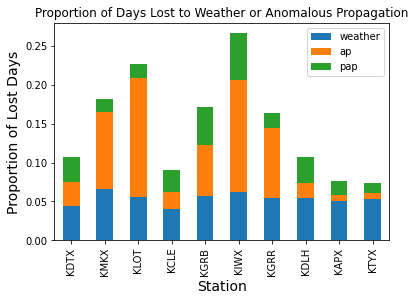

In [20]:
note_table_df.plot(x="station", kind="bar", stacked=True)

plt.xlabel("Station", fontsize=14)
plt.ylabel("Proportion of Lost Days", fontsize = 14)
plt.title("Proportion of Days Lost to Weather or Anomalous Propagation");

# Note: proportion will actually be slightly higher, because days with no detections are not
# added to the dataset.

## Get the Proportion of Days with False Negatives

Note: for each station, we can get the proportion of days with the note "miss", but this is not the actual proportion of false negatives because we didn't count the number of missing roosts on each day. 

In [21]:
miss_table = []

for station in df.station.unique():

    station_df = df[df.station == station]

    # Some stations have less than 6 years available, so we will correct for that:
    number_of_years = len(station_df.year.unique())

    # Get the number of days with note "miss"
    miss_df = station_df[station_df.day_notes == "miss"]
    miss_prop = len(miss_df.drop_duplicates(subset=["date"]))/(153*number_of_years)        
    miss_table.append([station, miss_prop])
        
miss_table_df = pd.DataFrame(miss_table, columns = ["station", "miss"])



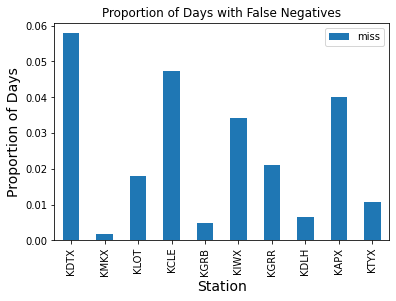

In [104]:
miss_table_df.plot(x="station", kind="bar")

plt.xlabel("Station", fontsize=14)
plt.ylabel("Proportion of Days", fontsize = 14)
plt.title("Proportion of Days with False Negatives");

In [58]:
# Take a sample of the data:
# roosts_sample = roosts.sample(6)

# output_file = "../../data/processed_data/test_batch/test_batch_raw_detections.csv"
# roosts_sample.to_csv(output_file, index = False)

In [18]:
# Write new df to file:
#output_file = "../../data/processed_data/" + batch + "/" + batch + "_raw_detections.csv"
#roosts.to_csv(output_file, index = False)